In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
from backstrip import backplot
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2024-10-14T21:08:24.890630+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

polars : 1.9.0
seaborn: 0.13.2
teeplot: 1.1.3

Watermark: 2.4.3



## Prep Data


In [4]:
cupy_perf = (
    pl.concat(
        [
            pl.read_parquet(
                "https://osf.io/jz3eq/download",
                use_pyarrow=True,
            ).with_columns(
                pl.lit("GPU A100").alias("hardware"),
                pl.lit("50/50 poisson").alias("experiment design"),
                pl.lit(256 * 243 * 243).alias("net population size"),
            ),
            pl.read_parquet(
                "https://osf.io/ya29p/download",
                use_pyarrow=True,
            ).with_columns(
                pl.lit("GPU A100").alias("hardware"),
                pl.lit("denovo poisson").alias("experiment design"),
                pl.lit(256 * 243 * 243).alias("net population size"),
            ),
        ],
    )
    .filter(pl.col("tile") == 0)
    .with_columns(
        (
            pl.col("net population size") / pl.col("tsc seconds per cycle")
        ).alias("throughput (agent-generations/sec)"),
    )
)
display(cupy_perf)
display(cupy_perf.describe())


tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
u64,f32,f32,f32,f32,u32,u32,u32,u64,u64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u16,u16,str,str,i32,f64
0,2612.250244,0.005225,191.405853,5224500.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.8934e9
0,2717.378662,0.005435,184.000854,5434757.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7815e9
0,2719.092773,0.005438,183.884872,5438185.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7797e9
0,2721.032471,0.005442,183.753784,5.442065e6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7777e9
0,2610.844727,0.005222,191.508911,5221689.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.8950e9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,2827.758789,0.005656,176.818466,5.655518e6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo poisson""",15116544,2.6729e9
0,2833.894287,0.005668,176.435669,5667788.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo poisson""",15116544,2.6671e9
0,2822.179199,0.005644,177.168045,5644358.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""denovo poisson""",15116544,2.6782e9


statistic,tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,"""90""","""90""",90.0,90.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0
"""mean""",0.0,2759.198242,0.005518,181.469513,5518396.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,2.7432e9
"""std""",0.0,103.762825,0.000208,6.924452,207525.640625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,1.0467e8
"""min""",0.0,2610.844727,0.005222,170.905243,5221689.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""GPU A100""","""50/50 poisson""",1.5116544e7,2.5835e9
"""25%""",0.0,2626.729492,0.005253,176.605942,5.253459e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,2.6697e9
"""50%""",0.0,2823.922119,0.005648,177.073914,5.647844e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,2.6767e9
"""75%""",0.0,2831.161865,0.005662,190.350769,5662323.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,2.8774e9
"""max""",0.0,2925.5979,0.005851,191.508911,5851195.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""GPU A100""","""denovo poisson""",1.5116544e7,2.8950e9


In [5]:
wse_perf = pl.concat(
    [
        pl.read_parquet(
            "https://osf.io/h3tu4/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("50/50 site-explicit").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
        pl.read_parquet(
            "https://osf.io/w97nx/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("denovo site-explicit").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
        pl.read_parquet(
            "https://osf.io/vh9pb/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("50/50 poisson").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
        pl.read_parquet(
            "https://osf.io/zp9gt/download",
            use_pyarrow=True,
        )
        .filter(pl.col("tile") == 749 * 993 - 1)
        .with_columns(
            pl.lit("WSE CS-2").alias("hardware"),
            pl.lit("denovo poisson").alias("experiment design"),
            pl.lit(256 * 750 * 994).alias("net population size"),
        ),
    ],
).with_columns(
    (pl.col("net population size") / pl.col("tsc seconds per cycle")).alias(
        "throughput (agent-generations/sec)"
    ),
)


In [6]:
df = pl.concat([cupy_perf, wse_perf])
display(df)
display(df.describe())


tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
u64,f32,f32,f32,f32,u32,u32,u32,u64,u64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u16,u16,str,str,i32,f64
0,2612.250244,0.005225,191.405853,5224500.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.8934e9
0,2717.378662,0.005435,184.000854,5434757.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7815e9
0,2719.092773,0.005438,183.884872,5438185.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7797e9
0,2721.032471,0.005442,183.753784,5.442065e6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7777e9
0,2610.844727,0.005222,191.508911,5221689.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.8950e9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
103685662536,121.983131,0.000244,4098.927246,243966.265625,1000003,4000008,500000,27523,103685690059,1000002,1000002,1000002,1000002,250001,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo poisson""",190848000,7.8227e11
103659336568,121.952164,0.000244,4099.968262,243904.328125,1000002,4000008,500000,27559,103659364127,1000002,1000002,1000002,1000002,250000,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo poisson""",190848000,7.8247e11
103683860081,121.98101,0.000244,4098.998535,243962.03125,1000000,4000008,500000,27558,103683887639,1000002,1000002,1000002,1000002,250000,250000,250000,250000,743756,991,506,"""WSE CS-2""","""denovo poisson""",190848000,7.8229e11


statistic,tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,"""342""","""342""",342.0,342.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0
"""mean""",8.5820e10,827.069763,0.001654,2800.49292,1.6541e6,736842.429825,2.9474e6,368421.052632,21461.988304,8.5820e10,736843.578947,736843.578947,736843.578947,736843.578947,184210.643275,184210.248538,184210.78655,184210.751462,548030.736842,730.210526,372.842105,null,null,1.4460288e8,5.2608e11
"""std""",5.3940e10,1157.736084,0.002315,1633.710938,2.315472e6,440992.774668,1.7640e6,220496.290181,13017.326909,5.3940e10,440993.462347,440993.462347,440993.462347,440993.462347,110248.215178,110247.978881,110248.300841,110248.279845,327990.8776,437.023647,223.142246,null,null,7.7496e7,3.2531e11
"""min""",0.0,110.615601,0.000221,170.905243,221231.203125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""GPU A100""","""50/50 poisson""",1.5116544e7,2.5835e9
"""25%""",0.0,121.953316,0.000244,191.037094,243906.625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,1.5116544e7,2.8878e9
"""50%""",1.0366e11,149.345856,0.000299,3496.033691,298691.6875,1e6,4.000008e6,500000.0,28195.0,1.0366e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250000.0,250000.0,250000.0,250000.0,743756.0,991.0,506.0,null,null,1.90848e8,6.6721e11
"""75%""",1.2156e11,2617.292725,0.005235,4099.929688,5234585.5,1.000002e6,4.000008e6,500000.0,28507.0,1.2156e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250001.0,250000.0,250001.0,250001.0,743756.0,991.0,506.0,null,null,1.90848e8,7.8246e11
"""max""",1.7584e11,2925.5979,0.005851,4520.158203,5851195.5,1.000004e6,4.000008e6,500000.0,35548.0,1.7584e11,1.000002e6,1.000002e6,1.000002e6,1.000002e6,250001.0,250001.0,250001.0,250001.0,743756.0,991.0,506.0,"""WSE CS-2""","""denovo site-explicit""",1.90848e8,8.6266e11


## Absolute performance


/usr/local/lib/python3.10/dist-packages/backstrip/_backplot.py:127: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.catplot(


teeplots/col=experiment-design+hue=hardware+orient=h+viz=backplot+x=throughput-agent-generations-sec+ext=.pdf
teeplots/col=experiment-design+hue=hardware+orient=h+viz=backplot+x=throughput-agent-generations-sec+ext=.png


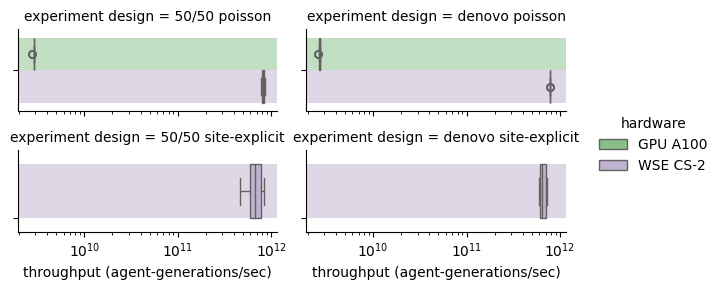

In [7]:
tp.tee(
    backplot,
    data=df.to_pandas(),
    col="experiment design",
    x="throughput (agent-generations/sec)",
    hue="hardware",
    aspect=2,
    col_wrap=2,
    height=1.5,
    orient="h",
    log_scale=(True, False),
    palette=sns.color_palette("Accent"),
    sharey=False,
    teeplot_outexclude="post",
    teeplot_postprocess="""
for ax in teed.axes.flat[2:]:
    ax.set_ylim(-0.1, 0.5)
""",
)


In [8]:
df.group_by("hardware", "experiment design",).agg(
    pl.col("throughput (agent-generations/sec)")
    .mean()
    .alias("mean_throughput"),
    pl.col("throughput (agent-generations/sec)").std().alias("std_throughput"),
    pl.col("tsc cycle hertz").mean().alias("mean_speed"),
    pl.col("tsc cycle hertz").std().alias("std_speed"),
)


hardware,experiment design,mean_throughput,std_throughput,mean_speed,std_speed
str,str,f64,f64,f32,f32
"""WSE CS-2""","""50/50 poisson""",8.2192e11,2.9740e10,4306.648438,155.83284
"""WSE CS-2""","""denovo poisson""",7.8222e11,5.2905e8,4098.675781,2.772118
"""WSE CS-2""","""50/50 site-explicit""",6.7028e11,1.1047e11,3512.122314,578.845947
"""GPU A100""","""50/50 poisson""",2.8646e9,3.9513e7,189.501465,2.613894
"""WSE CS-2""","""denovo site-explicit""",6.5376e11,5.4374e10,3425.558105,284.907532
"""GPU A100""","""denovo poisson""",2.6622e9,2.6056e7,176.114853,1.723704


## Relative Performance


In [9]:
# Step 1: Filter for GPU and calculate the mean throughput per experiment design
gpu_means = (
    df.filter(pl.col("hardware").str.contains("GPU"))
    .group_by("experiment design")
    .agg(pl.mean("throughput (agent-generations/sec)").alias("gpu_mean"))
)
print(gpu_means)

# Step 2: Join the GPU mean back to the original DataFrame
df_with_mean = df.join(gpu_means, on="experiment design", how="left")

# Step 3: Calculate the speedup by dividing throughput by the GPU mean
df_with_speedup = df_with_mean.with_columns(
    (pl.col("throughput (agent-generations/sec)") / pl.col("gpu_mean")).alias(
        "speedup"
    )
)

# Show the resulting DataFrame with speedup
df_with_speedup


shape: (2, 2)
┌───────────────────┬──────────┐
│ experiment design ┆ gpu_mean │
│ ---               ┆ ---      │
│ str               ┆ f64      │
╞═══════════════════╪══════════╡
│ 50/50 poisson     ┆ 2.8646e9 │
│ denovo poisson    ┆ 2.6622e9 │
└───────────────────┴──────────┘


tsc ticks,tsc seconds,tsc seconds per cycle,tsc cycle hertz,tsc ns per cycle,recv sum,send sum,cycle count,tsc start,tsc end,send N,send S,send E,send W,recv N,recv S,recv E,recv W,tile,row,col,hardware,experiment design,net population size,throughput (agent-generations/sec),gpu_mean,speedup
u64,f32,f32,f32,f32,u32,u32,u32,u64,u64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u16,u16,str,str,i32,f64,f64,f64
0,2612.250244,0.005225,191.405853,5224500.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.8934e9,2.8646e9,1.010049
0,2717.378662,0.005435,184.000854,5434757.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7815e9,2.8646e9,0.970973
0,2719.092773,0.005438,183.884872,5438185.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7797e9,2.8646e9,0.970361
0,2721.032471,0.005442,183.753784,5.442065e6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.7777e9,2.8646e9,0.969669
0,2610.844727,0.005222,191.508911,5221689.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""GPU A100""","""50/50 poisson""",15116544,2.8950e9,2.8646e9,1.010593
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
103685662536,121.983131,0.000244,4098.927246,243966.265625,1000003,4000008,500000,27523,103685690059,1000002,1000002,1000002,1000002,250001,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo poisson""",190848000,7.8227e11,2.6622e9,293.838935
103659336568,121.952164,0.000244,4099.968262,243904.328125,1000002,4000008,500000,27559,103659364127,1000002,1000002,1000002,1000002,250000,250000,250001,250001,743756,991,506,"""WSE CS-2""","""denovo poisson""",190848000,7.8247e11,2.6622e9,293.913565
103683860081,121.98101,0.000244,4098.998535,243962.03125,1000000,4000008,500000,27558,103683887639,1000002,1000002,1000002,1000002,250000,250000,250000,250000,743756,991,506,"""WSE CS-2""","""denovo poisson""",190848000,7.8229e11,2.6622e9,293.844036


/usr/local/lib/python3.10/dist-packages/backstrip/_backplot.py:127: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g = sns.catplot(


teeplots/hue=hardware+orient=h+viz=backplot+x=speedup+y=experiment-design+ext=.pdf
teeplots/hue=hardware+orient=h+viz=backplot+x=speedup+y=experiment-design+ext=.png


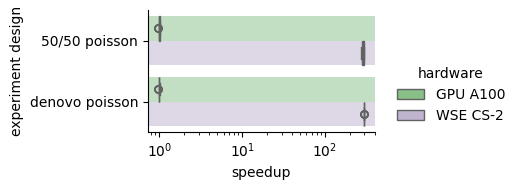

In [10]:
tp.tee(
    backplot,
    data=df_with_speedup.to_pandas(),
    y="experiment design",
    x="speedup",
    hue="hardware",
    aspect=2,
    height=2,
    order=["50/50 poisson", "denovo poisson"],
    orient="h",
    log_scale=(True, False),
    palette=sns.color_palette("Accent"),
)


In [11]:
df_with_speedup.group_by("hardware", "experiment design",).agg(
    pl.col("speedup").mean().alias("mean_speedup"),
    pl.col("speedup").std().alias("std_speedup"),
)


hardware,experiment design,mean_speedup,std_speedup
str,str,f64,f64
"""WSE CS-2""","""denovo poisson""",293.820973,0.198724
"""GPU A100""","""50/50 poisson""",1.0,0.013794
"""WSE CS-2""","""50/50 site-explicit""",null,null
"""WSE CS-2""","""50/50 poisson""",286.920722,10.382012
"""WSE CS-2""","""denovo site-explicit""",null,null
"""GPU A100""","""denovo poisson""",1.0,0.009787
